In [1]:
from nltk.corpus import wordnet as wn
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from concreteabstract import ConcreteAbstract
from collections import Counter

In [2]:
# Hyperparameters

concreteness_threshold = 4

# Number of positive examples we want for each classifier
pos_count = 5
neg_count = 10

test_pct = 0.3

embedding_file = 'ddata/clip.bertvocab.embeddings.513.txt'
embedding_pickle = 'ddata/clip.bertvocab.embeddings.513.pkl'
concreteness_file = 'ddata/AC_ratings_google3m_koeper_SiW.csv'
concreteness_pickle = 'ddata/AC_ratings_google3m_koeper_SiW.pkl'

In [3]:
# wac2vec

if os.path.isfile(embedding_pickle):
    wac2vec = pickle.load(open(embedding_pickle, 'rb'))
else:
    with open(embedding_file) as f:
        f = f.readlines()
        f = [line.split() for line in f]
        wac2vec = {line[0]:np.array(line[1:], dtype=np.float64) for line in f}
        pickle.dump(wac2vec, open(embedding_pickle, "wb" ))

len(wac2vec)

30522

In [4]:
# concr_scores

if os.path.isfile(concreteness_pickle):
    concr_scores = pickle.load(open(concreteness_pickle, 'rb'))
else:
    concr_scores = pd.read_csv(concreteness_file, delimiter='\t')
    concr_scores = concr_scores.dropna()
    concr_scores.WORD = concr_scores.WORD.apply(lambda x: x.replace("_", " "))
    concr_scores.index = concr_scores.WORD
    pickle.dump(concr_scores, open(concreteness_pickle, "wb" ))

len(concr_scores)

2168990

In [5]:
ca = ConcreteAbstract(wac2vec, concr_scores, wn, pos_count=pos_count, neg_count=neg_count)
ca.build_all(min_rating=concreteness_threshold, test_pct=test_pct, verbose=True)
score, rand_baseline = ca.evaluate_vs_distractors(10)
print("score:    ", score)
print("baseline: ", rand_baseline)

Initiate Abstraction Tree


  0%|          | 0/14510 [00:00<?, ?it/s]

Grow Abstraction Tree


  0%|          | 0/4861 [00:00<?, ?it/s]

Add Positive and Negative examples


  0%|          | 0/583 [00:00<?, ?it/s]

Fill out Train and Test sets


  0%|          | 0/583 [00:00<?, ?it/s]

Build Classifiers


  0%|          | 0/583 [00:00<?, ?it/s]

Done


  0%|          | 0/583 [00:00<?, ?it/s]

score:     0.3002724795640327
baseline:  0.0919569030318216


In [6]:
ca.set_verbose(False)

#### Evaluate (vs negative examples) 

In [7]:
ca.comp_most_common_baseline()

0.5172566764262265

In [8]:
ca.evaluate_vs_negative_examples()

0.6612814895947426

#### Evaluate (vs other classifiers) (i.e. Distractors)

In [9]:
X = range(2, 20)

In [10]:
scores_baselines = [ca.evaluate_vs_distractors(x) for x in X]

In [11]:
scores, baselines = zip(*scores_baselines)

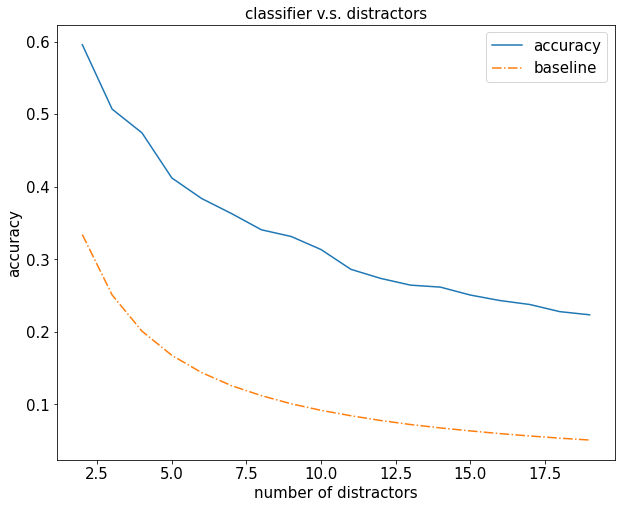

In [12]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.figure(figsize=(10,8))
plt.plot(X, scores, label="accuracy")
plt.plot(X, baselines, '-.', label="baseline")
plt.title('classifier v.s. distractors')
plt.ylabel('accuracy')
plt.xlabel('number of distractors')
plt.legend(loc="upper right")
plt.show()

In [13]:
scores[-1]

0.22343324250681199

In [14]:
baselines[-1]

0.05087048125970282

In [15]:
# High vs Low abstractness

In [16]:
# Number of Classifiers (Low)
len(ca._get_all_classifiers(min_leaf_dist=0, max_leaf_dist=4))

372

In [17]:
scores_baselines_low = [ca.evaluate_vs_distractors(x, min_leaf_dist=0, max_leaf_dist=4) for x in X]

In [18]:
scores_low, baselines_low = zip(*scores_baselines_low)

In [19]:
# Number of Classifiers (High)
len(ca._get_all_classifiers(min_leaf_dist=5, max_leaf_dist=50))

211

In [20]:
scores_baselines_high = [ca.evaluate_vs_distractors(x, min_leaf_dist=5, max_leaf_dist=50) for x in X]

In [21]:
scores_high, baselines_high = zip(*scores_baselines_high)

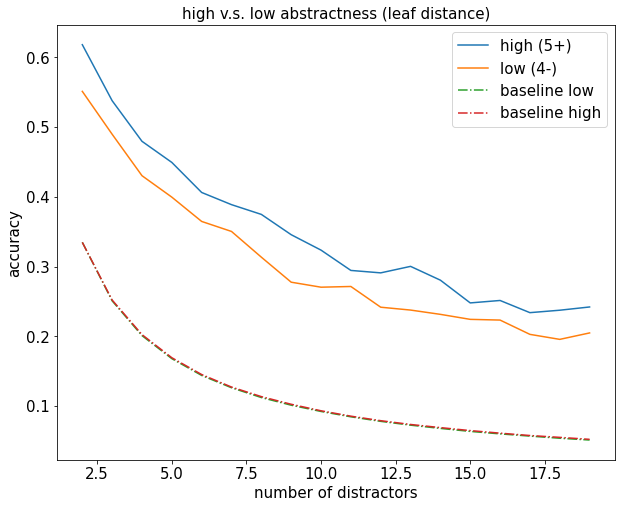

In [22]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

plt.figure(figsize=(10,8))

plt.plot(X, scores_high, label="high (5+)")
plt.plot(X, scores_low, label="low (4-)")
plt.plot(X, baselines_low, '-.', label="baseline low")
plt.plot(X, baselines_high, '-.', label="baseline high")
plt.title('high v.s. low abstractness (leaf distance)')
plt.ylabel('accuracy')
plt.xlabel('number of distractors')
plt.legend(loc="upper right")
plt.show()
plt.show()

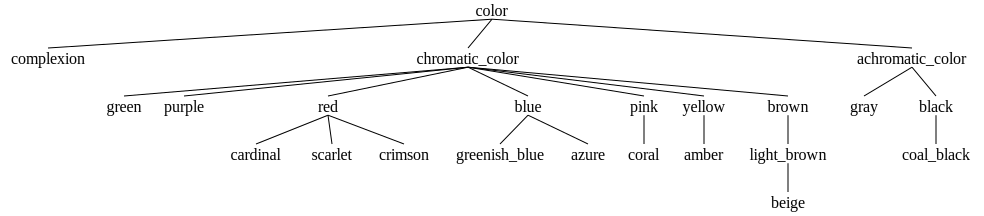

In [23]:
ca.build_display_tree(wn.synset('color.n.01'), char_limit=90)

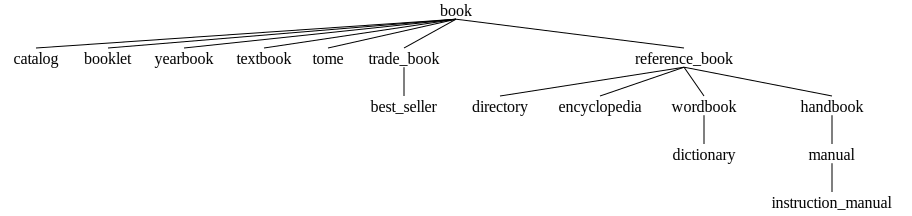

In [24]:
ca.build_display_tree(wn.synset('book.n.01'), char_limit=100)

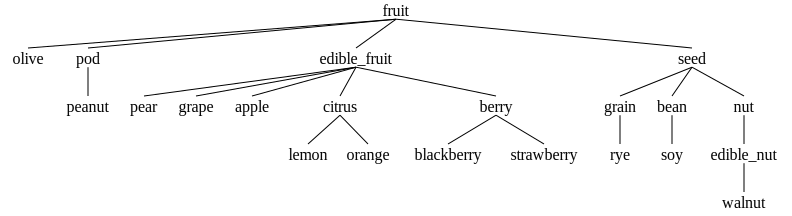

In [25]:
ca.build_display_tree(wn.synset('fruit.n.01'), char_limit=100)

In [30]:
ca.export_embeddings('ddata/new_embeddings')

New Embeddings Exported:  531
File:  ddata/new_embeddings_r4_p5_n10_t0.3_c531.txt
